# Downgrade TF (Necessário restart do Runtime) e LIME

In [1]:
!pip install tensorflow==2.4.1

In [2]:
!pip install tensorflow-gpu==2.4.1

In [3]:
!pip install lime

# Carregando Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


# Checando GPU

In [5]:
!nvidia-smi

Fri Oct  1 22:41:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Carregando Pacotes

In [6]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from pathlib import Path
import os
from matplotlib import pyplot as plt
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [7]:
print(tf.__version__)

2.4.1


# Parâmetros

In [8]:
# Tamanho imagem
img_rows, img_cols = 224, 224

input_shape = (img_rows, img_cols, 3)

#Batch size

batch_size = 32

#Path base de dados Drive
nome_base = 'oregon_wildlife'
nome_zip = nome_base + '.zip'
dir_path = Path('/content/drive/MyDrive/dataset/')
zip_path = dir_path/nome_zip

#modelo
nome_modelo = 'resnet50' 
dir_path_modelo = Path('/content/drive/MyDrive/modelos/')
zip_name = nome_modelo + '.zip'
drive_path_modelo = dir_path_modelo/zip_name

# Carregando Base de Dados

In [9]:
!cp {zip_path} .
!unzip -q {nome_zip} 
!rm {nome_zip}

In [10]:
path_train = '/content/' + nome_base + '/train'
path_test = '/content/' + nome_base + '/test'

In [11]:
train_dataset = image_dataset_from_directory(
        path_train,
        image_size=(img_rows, img_cols),
        color_mode="rgb",
        batch_size=batch_size,
        shuffle=False) # Manter Shuffle = False, pois não haverá treinamento
test_dataset = image_dataset_from_directory(
        path_test,
        image_size=(img_rows, img_cols),
        color_mode="rgb",
        batch_size=batch_size,
        shuffle=False)

Found 3136 files belonging to 14 classes.
Found 784 files belonging to 14 classes.


In [12]:
# Index para classe 
classes = train_dataset.class_names #Essa função e .file_paths não podem ser usados após o prefetch
classes_dict = dict(enumerate(classes)) 
print(classes_dict)

{0: 'bald_eagle', 1: 'black_bear', 2: 'bobcat', 3: 'canada_lynx', 4: 'columbian_black-tailed_deer', 5: 'cougar', 6: 'coyote', 7: 'deer', 8: 'gray_wolf', 9: 'raccoon', 10: 'red_fox', 11: 'sea_lions', 12: 'seals', 13: 'virginia_opossum'}


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE) #Otimização
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Carregando Modelo

In [14]:
!cp {drive_path_modelo} .
!unzip -q {zip_name} 
!rm {zip_name}

In [15]:
best_model = tf.keras.models.load_model(nome_modelo)

# Resultados

In [16]:
predict = best_model.predict(test_dataset)
predicted_classes = np.argmax(predict, axis=1)

In [17]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

In [18]:
print(confusion_matrix(y_true, predicted_classes))

[[55  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0 55  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 48  5  0  1  2  0  0  0  0  0  0  0]
 [ 0  0  6 47  0  1  0  0  2  0  0  0  0  0]
 [ 0  0  2  0 36  2  0 16  0  0  0  0  0  0]
 [ 0  0  0  2  1 52  0  0  0  1  0  0  0  0]
 [ 0  0  2  1  2  0 47  0  4  0  0  0  0  0]
 [ 0  0  1  0  6  1  0 48  0  0  0  0  0  0]
 [ 0  2  0  0  0  2  7  0 43  0  0  0  0  2]
 [ 0  1  1  0  0  0  0  0  0 53  0  0  0  1]
 [ 0  0  0  0  1  0  0  0  0  0 55  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0 51  4  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 13 43  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1 55]]


In [19]:
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        56
           1       0.95      0.98      0.96        56
           2       0.77      0.86      0.81        56
           3       0.84      0.84      0.84        56
           4       0.78      0.64      0.71        56
           5       0.88      0.93      0.90        56
           6       0.84      0.84      0.84        56
           7       0.75      0.86      0.80        56
           8       0.88      0.77      0.82        56
           9       0.98      0.95      0.96        56
          10       1.00      0.98      0.99        56
          11       0.80      0.91      0.85        56
          12       0.90      0.77      0.83        56
          13       0.95      0.98      0.96        56

    accuracy                           0.88       784
   macro avg       0.88      0.88      0.88       784
weighted avg       0.88      0.88      0.88       784



In [20]:
acc = accuracy_score(y_true, predicted_classes)
print("{:.4f}".format(acc))

0.8776


# Analisando Classe 10

In [21]:
class_index = 10
print(classes_dict[class_index]) 

red_fox


In [22]:
path_dir_red_fox =  path_test + '/red_fox/'

In [23]:
red_fox_dataset = test_dataset.unbatch().filter(lambda x, y: y == class_index).batch(batch_size)

In [24]:
predict_red_fox=best_model.predict(red_fox_dataset)
predict_red_fox_classes = np.argmax(predict_red_fox, axis=1)

In [25]:
list_index_red_fox = np.where(predict_red_fox_classes != class_index)

In [26]:
print(list_index_red_fox[0])

[54]


In [27]:
path_imgs = os.listdir(path_dir_red_fox)
path_imgs.sort()

In [28]:
for img_incorrect in list_index_red_fox[0]:
  print(path_imgs[img_incorrect])

fd647beef19fd8ab6c.jpg


# Análise de 1 imagem correta e 1 incorreta

## Imagem Correta (c2b8d79836b26b4843.jpg)

In [29]:
# Descobrindo o index da image
index_correta = path_imgs.index('c2b8d79836b26b4843.jpg')
print(index_correta)

19


In [30]:
imagem_correta, label_imagem_correta = list(red_fox_dataset.unbatch().as_numpy_iterator())[index_correta]

In [31]:
def decode(softmax):
    prob = []
    for key, value in classes_dict.items():
        prob_classe = softmax[key]
        prob.append((value, prob_classe))
    prob.sort(key=lambda x:x[1], reverse=True)
    return prob

Classe: red_fox - Probabilidade: 0.999867
Classe: coyote - Probabilidade: 0.000043
Classe: raccoon - Probabilidade: 0.000043


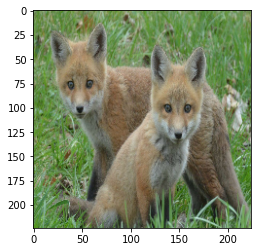

In [32]:
plt.imshow(imagem_correta/255)
preds = best_model.predict(np.expand_dims(imagem_correta, axis=0)) #Predição de uma única imagem
soft_preds=tf.nn.softmax(preds).numpy().flatten()
decode_prof=decode(soft_preds)
for list_prob in decode_prof[:3]:
    print('Classe: {} - Probabilidade: {:.6f}'.format(list_prob[0], list_prob[1])) 

https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb

In [33]:
explainer_correta = lime_image.LimeImageExplainer()

In [34]:
%%time
explanation_correta = explainer_correta.explain_instance(imagem_correta.astype('double'), best_model.predict, top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 24.1 s, sys: 715 ms, total: 24.8 s
Wall time: 24.7 s


### Para a Classe mais provável

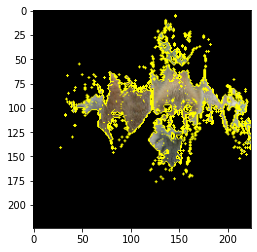

In [35]:
temp, mask = explanation_correta.get_image_and_mask(explanation_correta.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp /255, mask))

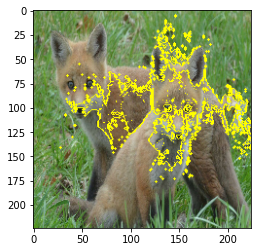

In [36]:
temp, mask = explanation_correta.get_image_and_mask(explanation_correta.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp /255, mask))

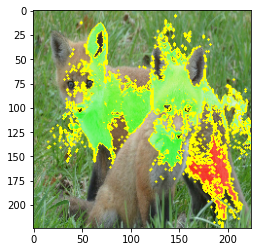

In [37]:
temp, mask = explanation_correta.get_image_and_mask(explanation_correta.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp /255, mask))

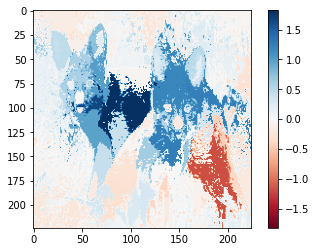

In [38]:
#Selecionar a classe mais provável
ind =  explanation_correta.top_labels[0]

#Mapeamento os pesos para cada explicação
dict_heatmap = dict(explanation_correta.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation_correta.segments) 

#Plot
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

### Para segunda classe mais provavel

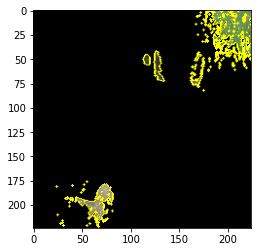

In [39]:
temp, mask = explanation_correta.get_image_and_mask(explanation_correta.top_labels[1], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp /255, mask))

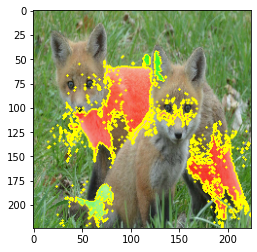

In [40]:
temp, mask = explanation_correta.get_image_and_mask(explanation_correta.top_labels[1], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp /255, mask))

## Imagem incorreta (fd647beef19fd8ab6c.jpg)


In [41]:
# Descobrindo o index da image
index_incorreta = path_imgs.index('fd647beef19fd8ab6c.jpg')
print(index_incorreta)

54


In [42]:
imagem_incorreta, label_imagem_incorreta = list(red_fox_dataset.unbatch().as_numpy_iterator())[index_incorreta]

Classe: columbian_black-tailed_deer - Probabilidade: 0.422399
Classe: red_fox - Probabilidade: 0.413120
Classe: deer - Probabilidade: 0.120777


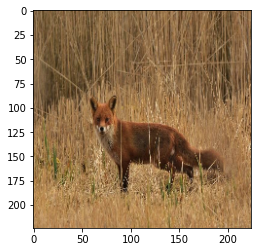

In [43]:
plt.imshow(imagem_incorreta/255)
preds = best_model.predict(np.expand_dims(imagem_incorreta, axis=0)) #Predição de uma única imagem
soft_preds=tf.nn.softmax(preds).numpy().flatten()
decode_prof=decode(soft_preds)
for list_prob in decode_prof[:3]:
    print('Classe: {} - Probabilidade: {:.6f}'.format(list_prob[0], list_prob[1])) 

In [44]:
explainer_incorreta = lime_image.LimeImageExplainer()

In [45]:
%%time
explanation_incorreta = explainer_incorreta.explain_instance(imagem_incorreta.astype('double'), best_model.predict, top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 22.4 s, sys: 593 ms, total: 23 s
Wall time: 22.8 s


### Classe mais provável

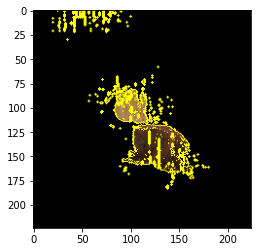

In [46]:
temp, mask = explanation_incorreta.get_image_and_mask(explanation_incorreta.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp /255, mask))

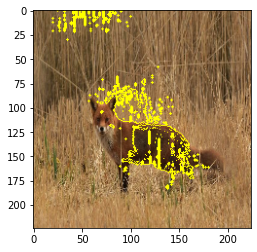

In [47]:
temp, mask = explanation_incorreta.get_image_and_mask(explanation_incorreta.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp /255, mask))

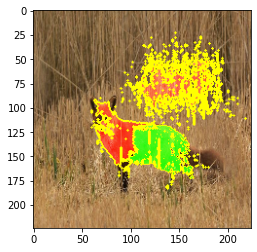

In [48]:
temp, mask = explanation_incorreta.get_image_and_mask(explanation_incorreta.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp /255, mask))

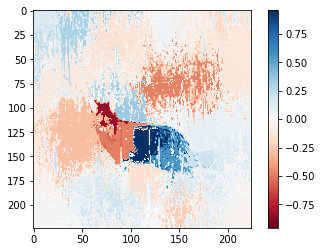

In [49]:
#Selecionam a classe mais provável
ind =  explanation_incorreta.top_labels[0]

#Mapeamento os pesos para cada explicação
dict_heatmap = dict(explanation_incorreta.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation_incorreta.segments) 

#Plot
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

### Para segunda classe mais provavel

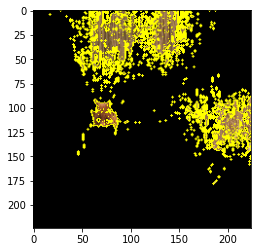

In [50]:
temp, mask = explanation_incorreta.get_image_and_mask(explanation_incorreta.top_labels[1], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp /255, mask))

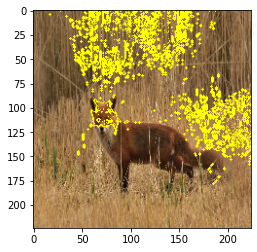

In [51]:
temp, mask = explanation_incorreta.get_image_and_mask(explanation_incorreta.top_labels[1], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp /255, mask))

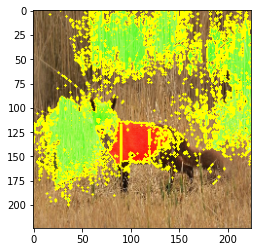

In [52]:
temp, mask = explanation_incorreta.get_image_and_mask(explanation_incorreta.top_labels[1], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp /255, mask))

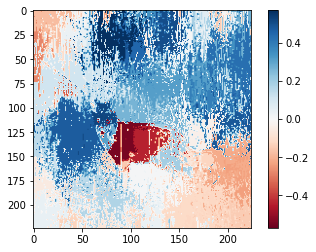

In [53]:
#Selecionar a segunda classe mais provável
ind =  explanation_incorreta.top_labels[1]

#Mapeamento os pesos para cada explicação
dict_heatmap = dict(explanation_incorreta.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation_incorreta.segments) 

#Plot
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()